
# ⏳ Prévision Temporelle des Coûts (Time Series)

## Objectif
Ce notebook a pour but d'entraîner un modèle spécifique capable de prédire les coûts de traitement des déchets pour une **date future donnée**.

Contrairement au modèle classique qui se base sur les caractéristiques du déchet (type, poids, etc.), ce modèle se concentre sur l'**historique temporel** et les **tendances** par hôpital.

### Étapes :
1.  Chargement des données.
2.  **Feature Engineering Temporel** : Création de variables explicatives à partir de la date (année, mois, jour, jour de la semaine...).
3.  **Encodage** : Transformation des noms d'hôpitaux en valeurs numériques.
4.  **Entraînement** : Utilisation d'un RandomForestRegressor.
5.  **Sauvegarde** : Export du modèle pour l'application Web.


In [1]:

import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Configuration pour l'affichage
sns.set(style="whitegrid")
%matplotlib inline

# Définition des chemins
BASE_DIR = "../../web_app"
DATA_PATH = "../../notebooks/data/dechets_hospitaliers.csv"
MODELS_DIR = os.path.join(BASE_DIR, "models")

# Création du dossier models s'il n'existe pas
os.makedirs(MODELS_DIR, exist_ok=True)


## 1. Chargement des Données

In [2]:

print("Chargement du dataset...")
df = pd.read_csv(DATA_PATH)

# Conversion de la colonne date
df['date_collecte'] = pd.to_datetime(df['date_collecte'])

display(df.head())
df.info()


Chargement du dataset...


,id,hopital,pays,region,type_dechet,poids_kg,cout_traitement,niveau_risque,mode_elimination,date_collecte,distance_traitement_km,conformite,type_conteneur,incident,entreprise_transport,service_origine
0,571,Hôpital Régional de Thiès,Sénégal,Fatick,Radioactifs,201.49,32767.38,Moyen,Incinération,2023-03-30,54.89,Non,Sac rouge,Non,SafeWaste,Radiologie
1,241,Hôpital Laquintinie de Douala,Cameroun,Centre,Piqûres/Coupures,214.32,26431.70,Élevé,Autoclave,2024-07-07,86.71,En attente,Sac rouge,Non,CleanMed,Urgences
2,294,Hôpital Dogta-Lafiè,Togo,Centrale,Organiques,17.56,423.84,Faible,Enfouissement,2024-09-18,86.09,Partielle,Conteneur rigide,Non,NaN,Restauration
3,670,CHR Lomé Commune,Togo,Savanes,Piqûres/Coupures,39.35,4702.25,Élevé,Autoclave,2023-01-08,25.31,En attente,Sac rouge,Non,Hopital Service,Chirurgie
4,475,CHR Dapaong,Togo,Savanes,Pharmaceutiques,243.51,55352.35,Élevé,Incinération,2023-03-11,29.23,NaN,Sac jaune,Non,SafeWaste,Oncologie


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      735 non-null    int64         
 1   hopital                 735 non-null    object        
 2   pays                    735 non-null    object        
 3   region                  735 non-null    object        
 4   type_dechet             735 non-null    object        
 5   poids_kg                735 non-null    float64       
 6   cout_traitement         735 non-null    float64       
 7   niveau_risque           735 non-null    object        
 8   mode_elimination        735 non-null    object        
 9   date_collecte           735 non-null    datetime64[ns]
 10  distance_traitement_km  735 non-null    float64       
 11  conformite              677 non-null    object        
 12  type_conteneur          735 non-null    object    


## 2. Feature Engineering Temporel

Pour qu'un modèle puisse comprendre la notion de "temps" et de "saisonnalité", nous devons décomposer la date en plusieurs caractéristiques numériques :
*   **Année** : Pour capter la tendance globale (inflation, augmentation du volume...).
*   **Mois** : Pour la saisonnalité annuelle.
*   **Jour du mois** : Pour les cycles mensuels.
*   **Jour de la semaine** : Pour les cycles hebdomadaires (ex: moins de collectes le week-end).
*   **Jour de l'année** : Pour une granularité fine.


In [3]:

df['annee'] = df['date_collecte'].dt.year
df['mois'] = df['date_collecte'].dt.month
df['jour'] = df['date_collecte'].dt.day
df['jour_semaine'] = df['date_collecte'].dt.dayofweek
df['jour_annee'] = df['date_collecte'].dt.dayofyear

print("Aperçu des nouvelles features temporelles :")
display(df[['date_collecte', 'annee', 'mois', 'jour', 'jour_semaine']].head())


Aperçu des nouvelles features temporelles :


,date_collecte,annee,mois,jour,jour_semaine
0,2023-03-30,2023,3,30,3
1,2024-07-07,2024,7,7,6
2,2024-09-18,2024,9,18,2
3,2023-01-08,2023,1,8,6
4,2023-03-11,2023,3,11,5



## 3. Encodage des Hôpitaux

Le modèle a besoin de savoir pour quel hôpital il prédit. Comme les algorithmes ne comprennent que les nombres, nous utilisons un **LabelEncoder** pour transformer chaque nom d'hôpital en un nombre unique entier.

Il est CRUCIAL de sauvegarder cet encodeur pour que l'application Web puisse transformer les choix de l'utilisateur de la même manière.


In [4]:

le_hopital = LabelEncoder()
df['hopital_encoded'] = le_hopital.fit_transform(df['hopital'])

# Vérification
print(f"Nombre d'hôpitaux uniques : {len(le_hopital.classes_)}")
display(df[['hopital', 'hopital_encoded']].head())


Nombre d'hôpitaux uniques : 82


,hopital,hopital_encoded
0,Hôpital Régional de Thiès,68
1,Hôpital Laquintinie de Douala,53
2,Hôpital Dogta-Lafiè,44
3,CHR Lomé Commune,5
4,CHR Dapaong,4


## 4. Visualisation de l'Évolution Temporelle

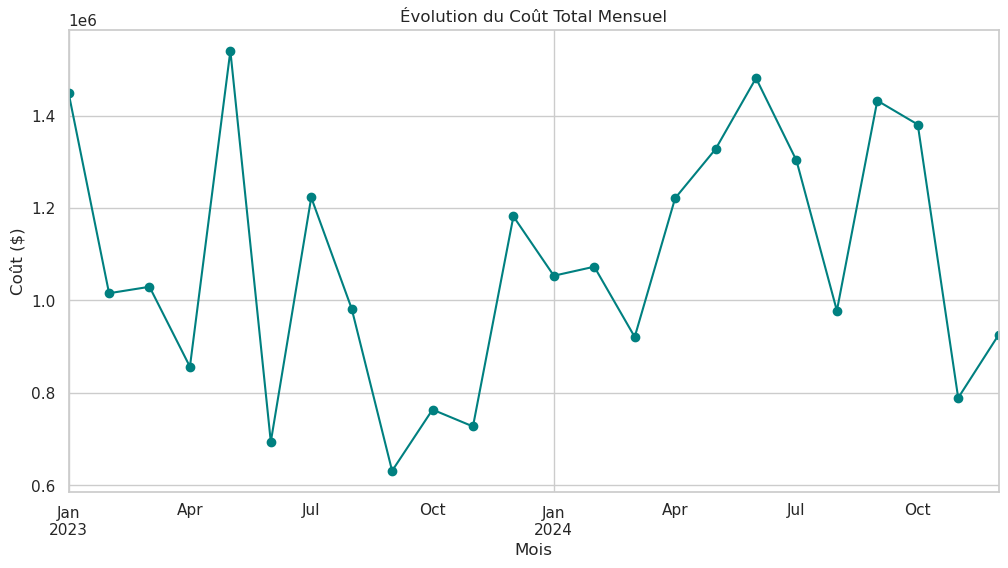

In [5]:

# Agrégation par mois pour voir la tendance globale
df['mois_annee'] = df['date_collecte'].dt.to_period('M')
monthly_cost = df.groupby('mois_annee')['cout_traitement'].sum()

plt.figure(figsize=(12, 6))
monthly_cost.plot(kind='line', marker='o', color='teal')
plt.title('Évolution du Coût Total Mensuel')
plt.ylabel('Coût ($)')
plt.xlabel('Mois')
plt.grid(True)
plt.show()



## 5. Entraînement du Modèle

Nous utilisons un **RandomForestRegressor**. C'est un modèle robuste capable de capturer des relations non-linéaires complexes entre la date, l'hôpital et le coût.


In [6]:

# Définition des features (X) et de la cible (y)
features_cols = ['hopital_encoded', 'annee', 'mois', 'jour', 'jour_semaine', 'jour_annee']
X = df[features_cols]
y = df['cout_traitement']

print("Entraînement du modèle en cours...")
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X, y)

print("✅ Modèle entraîné avec succès.")

# Évaluation rapide (Score R2 sur le train set - pour validation simple)
score = model.score(X, y)
print(f"Score R² (sur données d'entraînement) : {score:.4f}")


Entraînement du modèle en cours...
✅ Modèle entraîné avec succès.
Score R² (sur données d'entraînement) : 0.8385



## 6. Sauvegarde des Artefacts

Nous sauvegardons :
1.  Le modèle entraîné (`model_future_cout.pkl`).
2.  L'encodeur des hôpitaux (`encoder_hopital_future.pkl`).

Ces fichiers seront chargés par l'application Flask via le fichier `future_routes.py`.


In [7]:

model_path = os.path.join(MODELS_DIR, 'model_future_cout.pkl')
encoder_path = os.path.join(MODELS_DIR, 'encoder_hopital_future.pkl')

joblib.dump(model, model_path)
joblib.dump(le_hopital, encoder_path)

print(f"Modèle sauvegardé sous : {model_path}")
print(f"Encodeur sauvegardé sous : {encoder_path}")


Modèle sauvegardé sous : ../../web_app/models/model_future_cout.pkl
Encodeur sauvegardé sous : ../../web_app/models/encoder_hopital_future.pkl
